[View in Colaboratory](https://colab.research.google.com/github/shreyas-kalmegh/time-series-AV/blob/master/timeSeries.ipynb)

## Import Libraries

In [0]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 8)

## Problem statement

Congratulations on your new job! This time you are helping out Unicorn Investors with your data hacking skills. They are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

Evaluation Metric:

Root Mean Squre Error (RMSE) is the evaluation metric for this contest

Note: Public and private split is 20:80 where first 44 days in public and next 169 days in private 

## Hypothesis

 - There might be an inreasing trend over time
 - Traffic may be high in holiday season i.e May to October
 - Traffic during weekdays may be higher than weekends
 - Traffic may be high during peak hours

## Load the dataset

In [14]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test (2).csv
Saving train.csv to train (2).csv
User uploaded file "test.csv" with length 122701 bytes
User uploaded file "train.csv" with length 489054 bytes


In [15]:
import io
train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))

train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [5]:
test.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [6]:
train.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [0]:
Datetimetrain = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.Datetime = Datetimetrain
train.set_index('Datetime', inplace=True)

Datetimetest = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.Datetime = Datetimetest
test.set_index('Datetime', inplace=True)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18288 entries, 2012-08-25 00:00:00 to 2014-09-25 23:00:00
Data columns (total 2 columns):
ID       18288 non-null int64
Count    18288 non-null int64
dtypes: int64(2)
memory usage: 428.6 KB


## Extract Features

In [0]:
for i in (train, test):
  i['year'] = i.index.year
  i['month'] = i.index.month
  i['day'] = i.index.day
  i['day_of_week'] = i.index.dayofweek
  i['hour'] = i.index.hour

In [13]:
train.head()

,ID,Count,year,month,day,day_of_week,hour
Datetime,,,,,,,
2012-08-25 00:00:00,0,8,2012,8,25,5,0
2012-08-25 01:00:00,1,2,2012,8,25,5,1
2012-08-25 02:00:00,2,6,2012,8,25,5,2
2012-08-25 03:00:00,3,2,2012,8,25,5,3
2012-08-25 04:00:00,4,2,2012,8,25,5,4


In [14]:
test.head()

,ID,year,month,day,day_of_week,hour
Datetime,,,,,,
2014-09-26 00:00:00,18288,2014,9,26,4,0
2014-09-26 01:00:00,18289,2014,9,26,4,1
2014-09-26 02:00:00,18290,2014,9,26,4,2
2014-09-26 03:00:00,18291,2014,9,26,4,3
2014-09-26 04:00:00,18292,2014,9,26,4,4


## EDA

#### HOUR

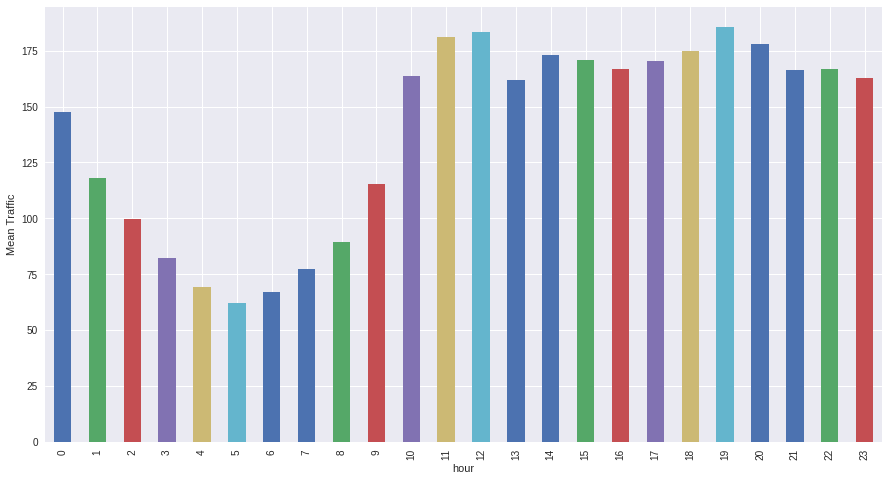

In [19]:
train.groupby('hour')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

#### Traffic decreases after 12 am till 5 am.

#### DAY OF WEEK

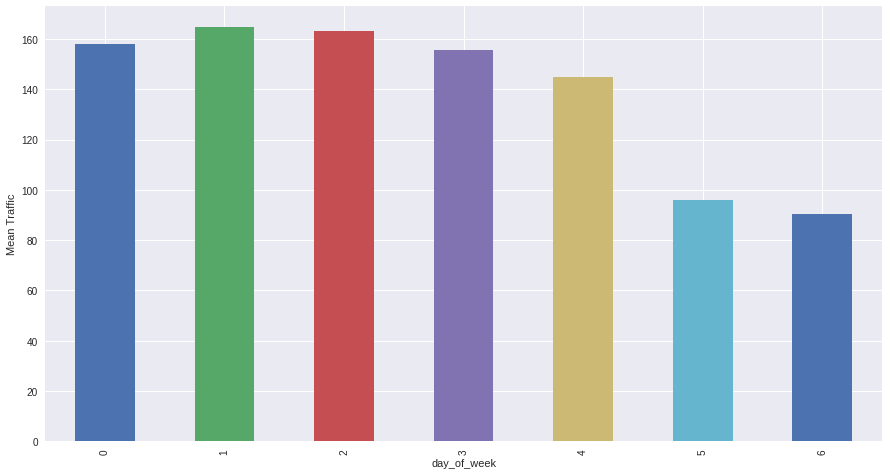

In [20]:
train.groupby('day_of_week')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

##### There are some seasonal properties. Traffic may be low on week ends.

#### DAY OF MONTH

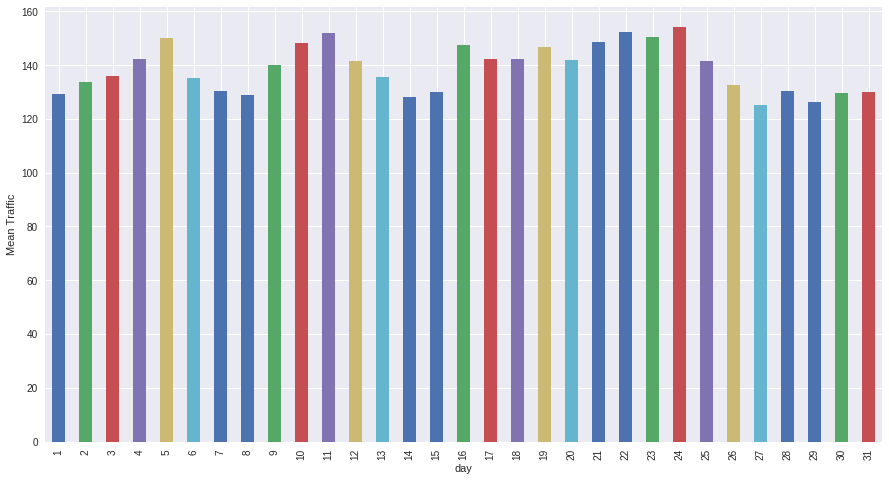

In [21]:
train.groupby('day')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

#### A lot of noise is present.

#### MONTH

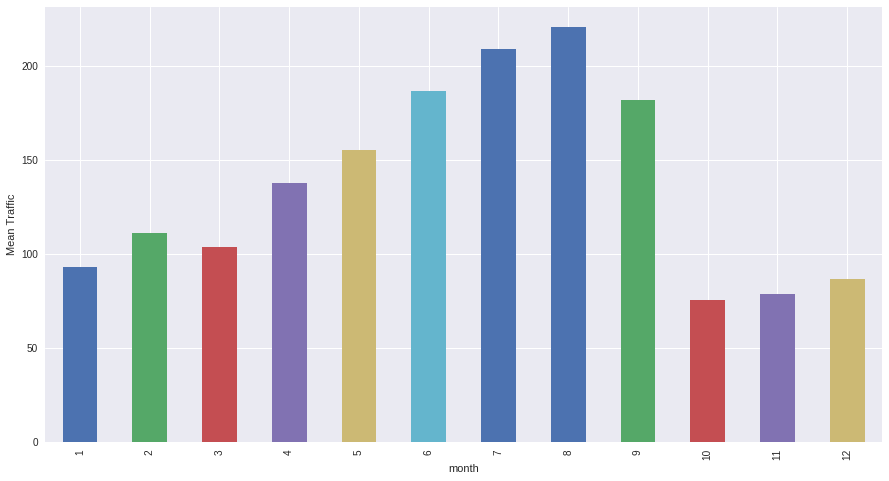

In [22]:
train.groupby('month')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

##### Seasonal properties can be seen here. Traffic is very low in months october, november and december. Traffic increases gradually from april.

#### YEAR

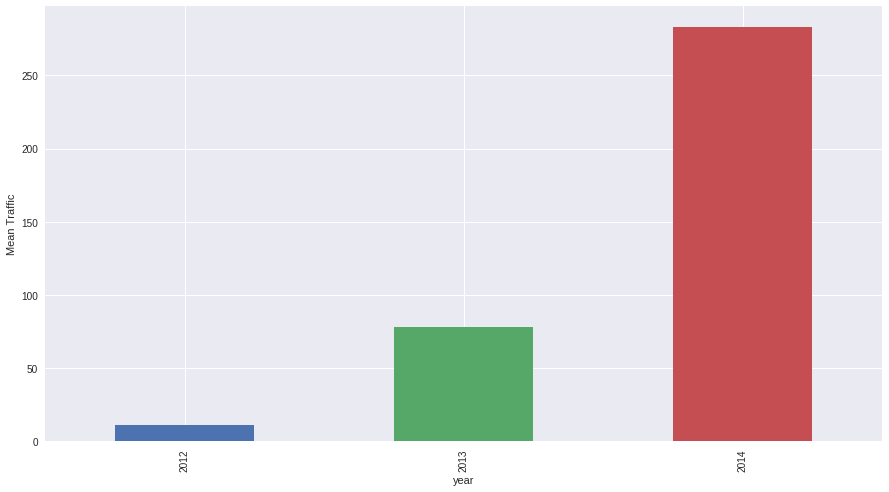

In [23]:
train.groupby('year')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

##### There is an increasing trend. Traffic seems to increase exponentially over the years.

### AGGREGATED SERIES

#### Daily

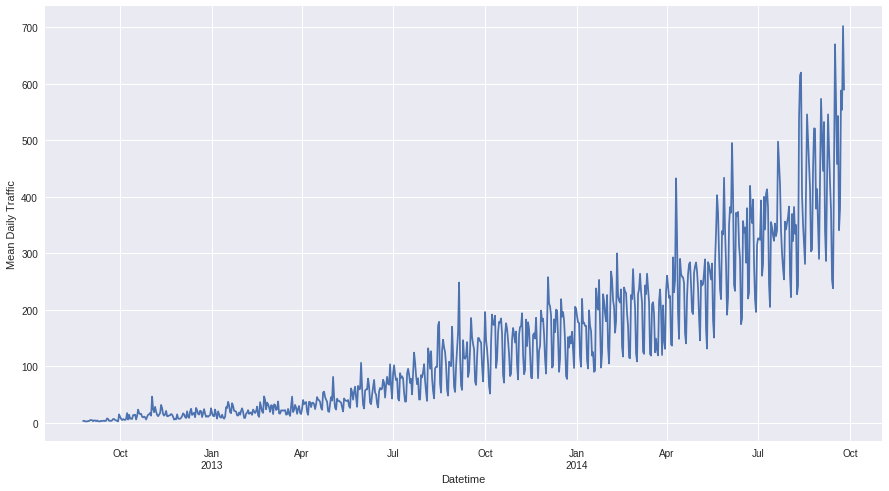

In [24]:
train.Count.resample('D').mean().plot()
plt.ylabel('Mean Daily Traffic')
plt.show()

#### Monthly

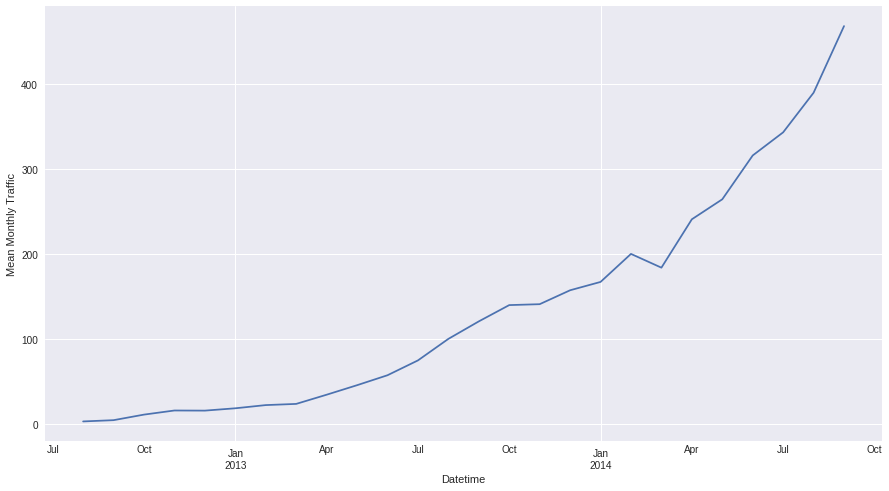

In [25]:
train.Count.resample('M').mean().plot()
plt.ylabel('Mean Monthly Traffic')
plt.show()

#### Yearly

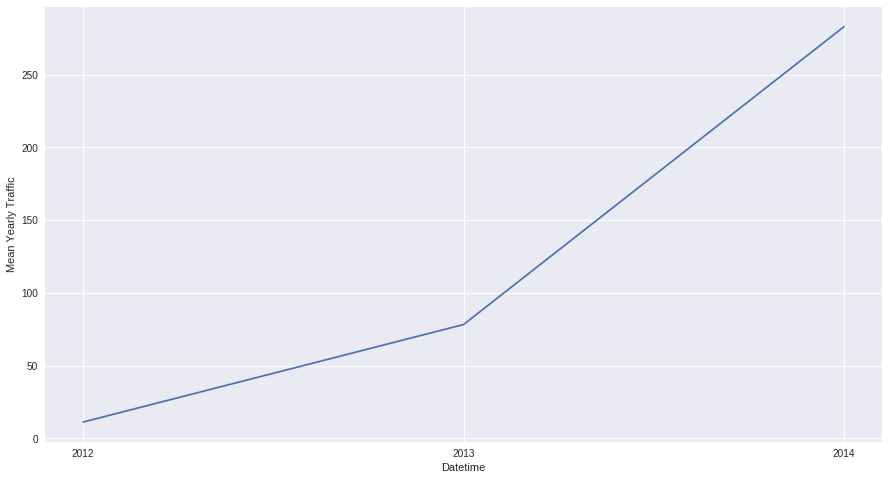

In [26]:
train.Count.resample('Y').mean().plot()
plt.ylabel('Mean Yearly Traffic')
plt.show()

## Inferences



*  There is an exponentially increasing trend.
*  There might be multiple seasonalities. Weekly and Monthly




   





## Approach

### We will model for day of the week instead of hour.

## Create New Series (Daily).

In [27]:
trainDay = train.Count.resample('D').sum()
trainDay.tail()

Datetime
2014-09-21     9102
2014-09-22    14116
2014-09-23    13304
2014-09-24    16856
2014-09-25    14152
Freq: D, Name: Count, dtype: int64

## Check For Stationarity.

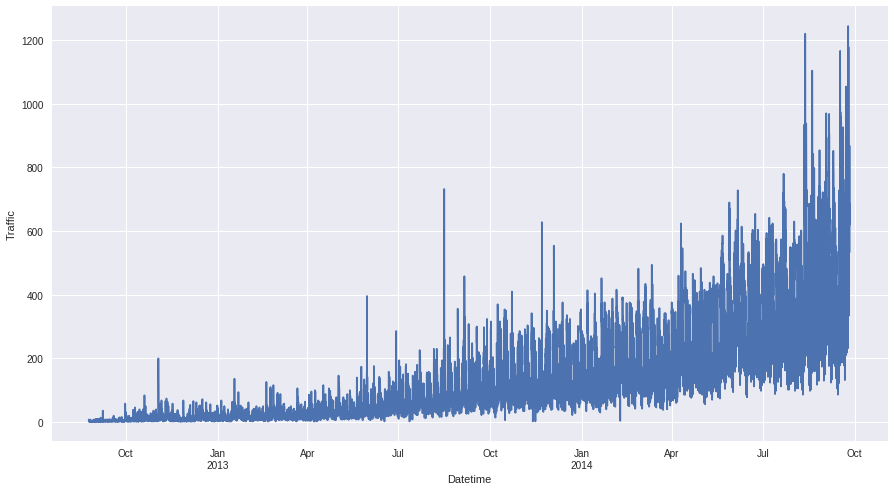

In [28]:
train.Count.plot()
plt.ylabel('Traffic')
plt.show()

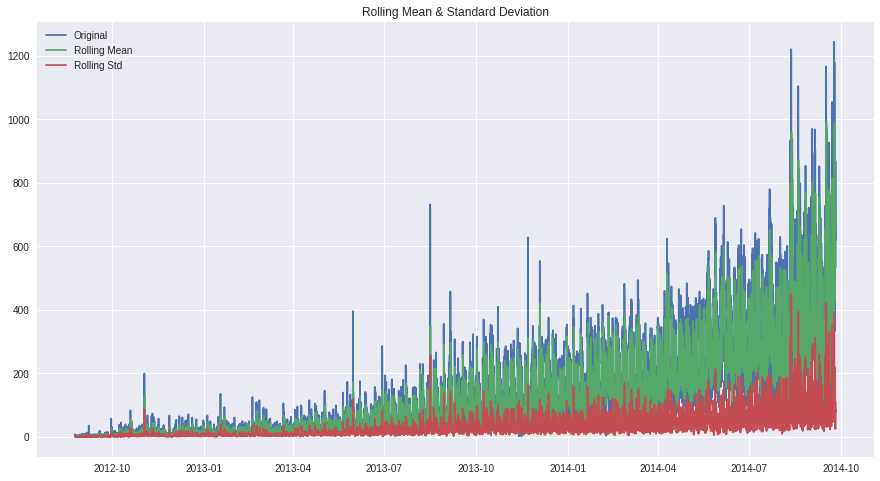

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [31]:
from statsmodels.tsa.stattools import adfuller

def adfTest(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7, center=False).mean()
    rolstd = timeseries.rolling(window=7, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean, label='Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
  
adfTest(train.Count)  

#### As we have already seen in the aggregated series plots variance and level is time dependent. Seasonality is also present. Hence Series is NOT STATIONARY.

#### Remove time dependece of variance.

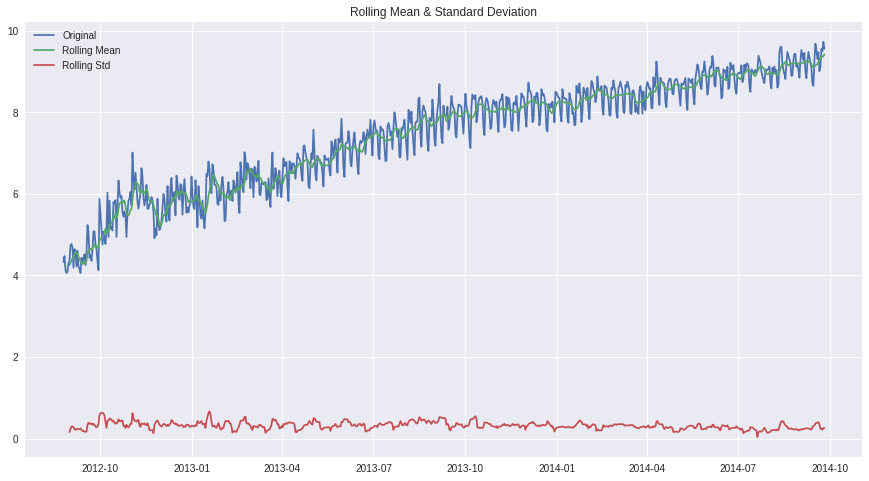

Results of Dickey-Fuller Test:
Test Statistic                  -2.413296
p-value                          0.138019
#Lags Used                      20.000000
Number of Observations Used    741.000000
Critical Value (1%)             -3.439206
Critical Value (5%)             -2.865448
Critical Value (10%)            -2.568851
dtype: float64


In [32]:
trainDay['log'] = np.log(trainDay)
adfTest(trainDay.log)


#### Remove Trend.

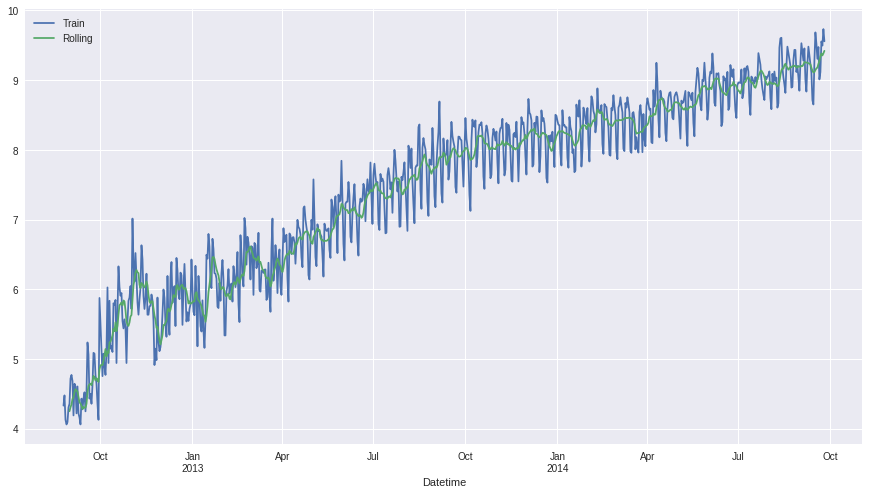

In [35]:
trainDaylogRoll = trainDay.log.rolling(window=7, center=False).mean()

trainDay.log.plot(label='Train')
trainDaylogRoll.plot(label='Rolling')
plt.legend(loc='best')
plt.show()


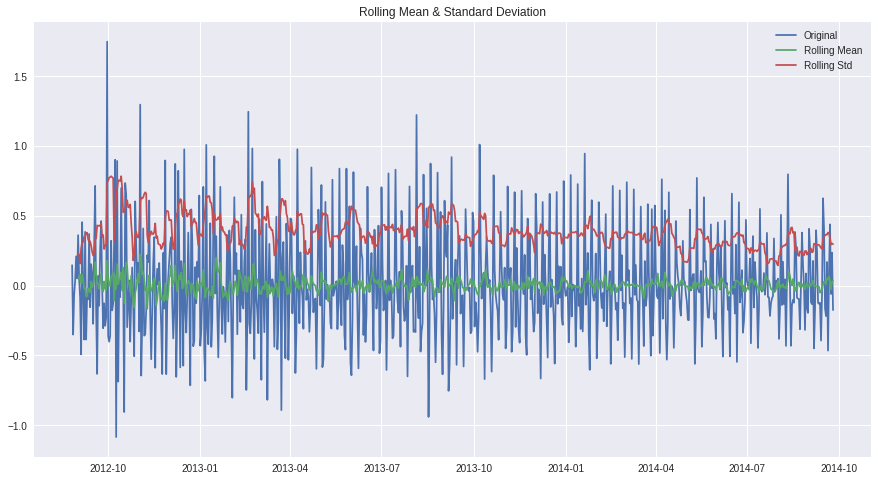

Results of Dickey-Fuller Test:
Test Statistic                -8.877418e+00
p-value                        1.346196e-14
#Lags Used                     1.900000e+01
Number of Observations Used    7.410000e+02
Critical Value (1%)           -3.439206e+00
Critical Value (5%)           -2.865448e+00
Critical Value (10%)          -2.568851e+00
dtype: float64


In [36]:
trainDay['log_first_diff'] = trainDay.log - trainDay.log.shift(1)

adfTest(trainDay['log_first_diff'].dropna())

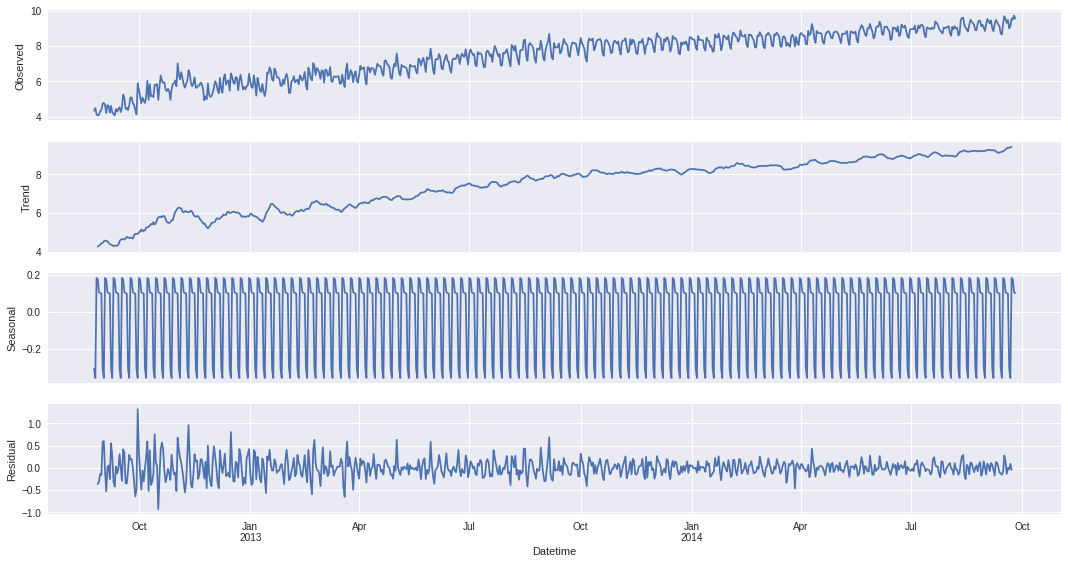

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(trainDay.log, freq=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()



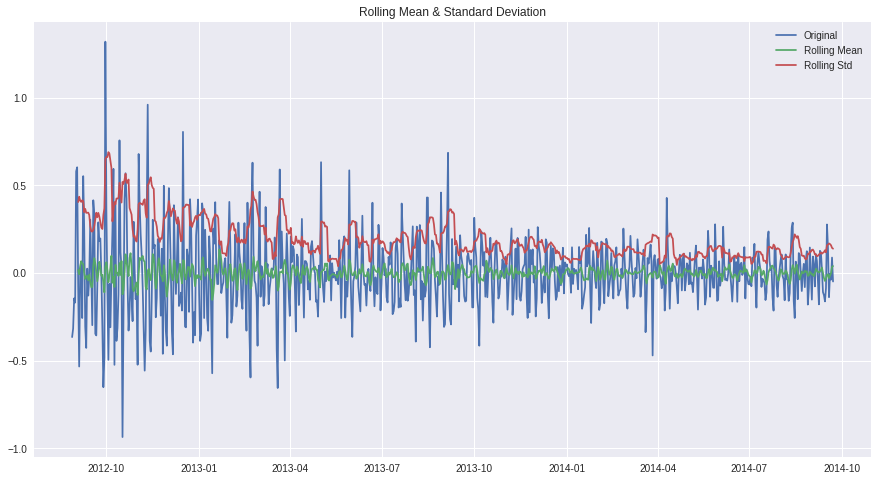

Results of Dickey-Fuller Test:
Test Statistic                -1.142413e+01
p-value                        6.760311e-21
#Lags Used                     2.000000e+01
Number of Observations Used    7.350000e+02
Critical Value (1%)           -3.439278e+00
Critical Value (5%)           -2.865480e+00
Critical Value (10%)          -2.568868e+00
dtype: float64


In [38]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
adfTest(ts_log_decompose)

#### The p-value is very less. Series is stationary.

## Stationary series:

*  Take Log.
*  Take the first difference of log.

*  Take seasonal difference(7) of first difference of log.






## ARIMA

### Select orders od AR and MA terms.

#### Autocorrelation and Partial Correlation Plots

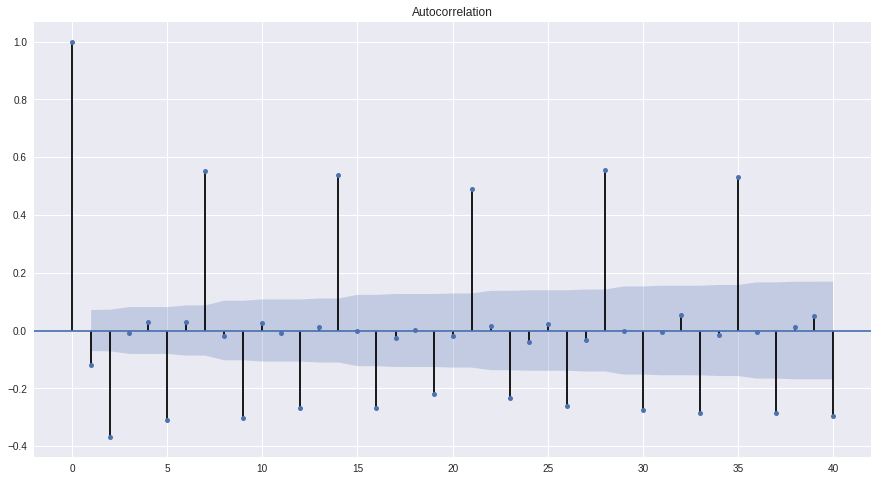

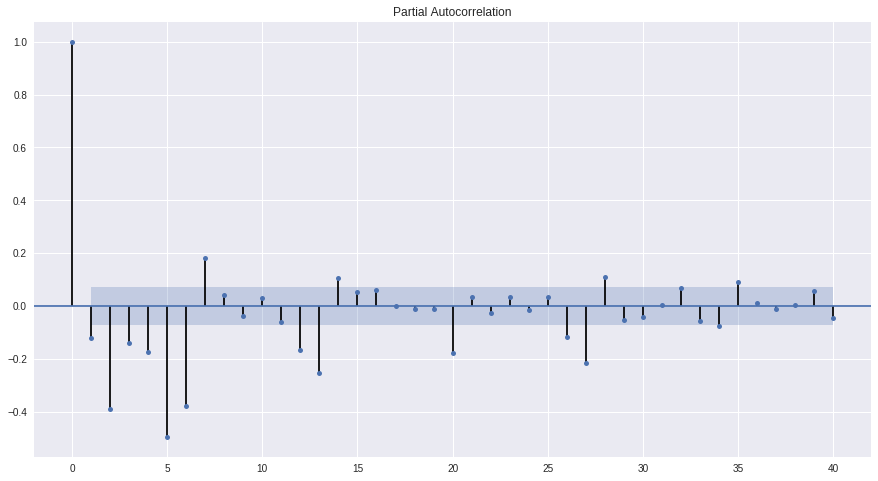

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(trainDay['log_first_diff'].dropna(), lags=40)
plt.show()
plot_pacf(trainDay['log_first_diff'].dropna(), lags=40)
plt.show()

#### Seasonal Adjustment.

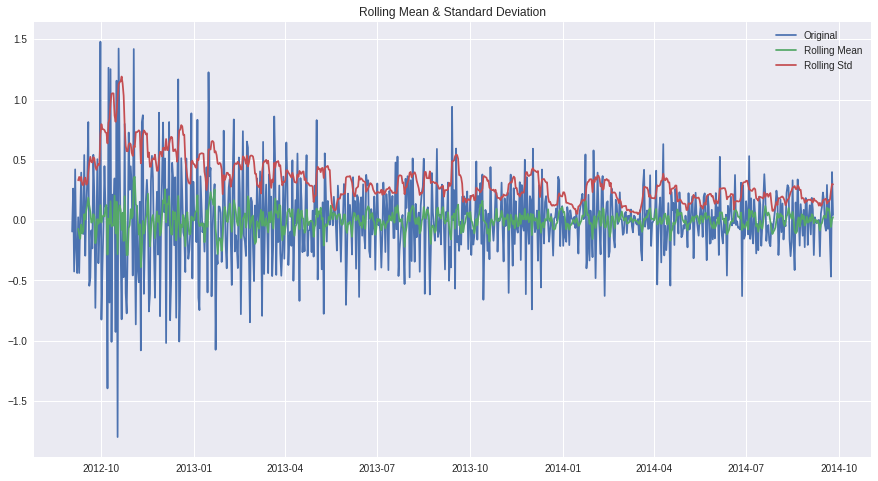

Results of Dickey-Fuller Test:
Test Statistic                -9.597688e+00
p-value                        1.958258e-16
#Lags Used                     2.000000e+01
Number of Observations Used    7.330000e+02
Critical Value (1%)           -3.439303e+00
Critical Value (5%)           -2.865491e+00
Critical Value (10%)          -2.568874e+00
dtype: float64


In [39]:
trainDay['seasonal'] = trainDay['log_first_diff'] - trainDay['log_first_diff'].shift(7)
adfTest(trainDay['seasonal'].dropna())

#### Autocorrelation and Partial Correlation Plots

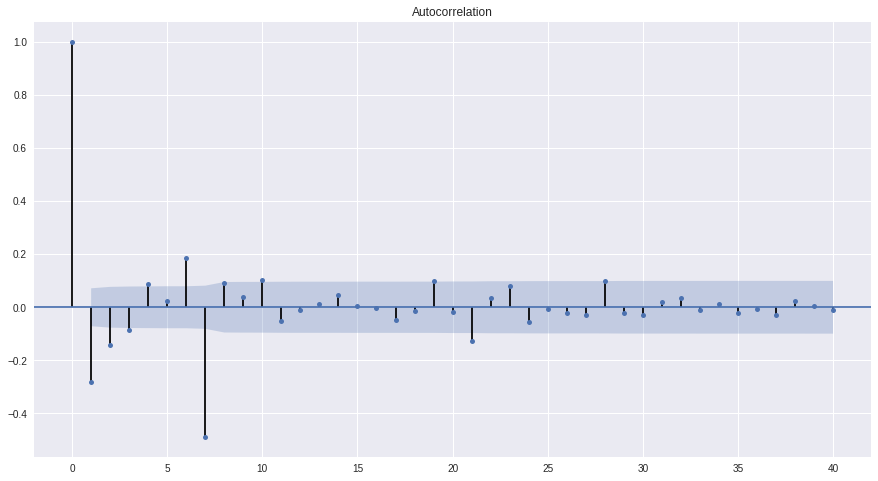

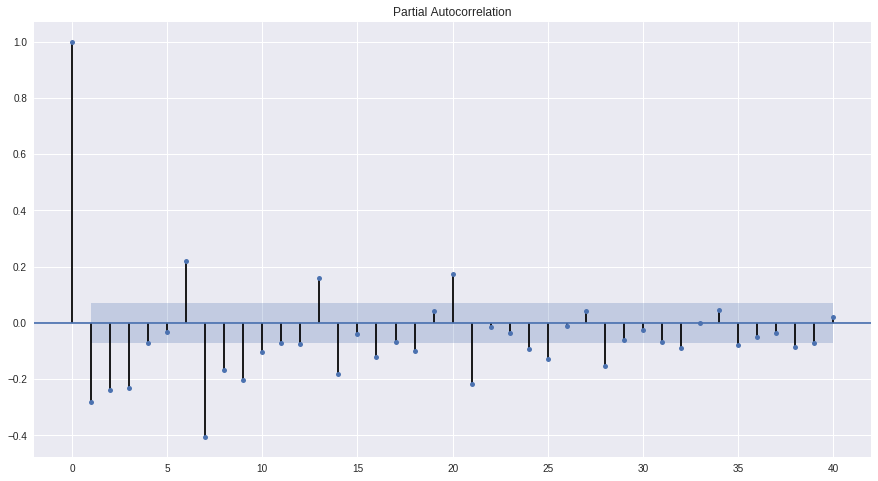

In [59]:
plot_acf(trainDay.seasonal.dropna(), lags=40)
plt.show()
plot_pacf(trainDay.seasonal.dropna(), lags=40)
plt.show()

#### AR = 6, MA = 6, D = 1, S = 7

### Create Model

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Count   No. Observations:                  762
Model:             SARIMAX(6, 1, 6)x(0, 1, 1, 7)   Log Likelihood                  22.997
Date:                           Sat, 12 May 2018   AIC                            -17.995
Time:                                   08:11:56   BIC                             46.908
Sample:                               08-25-2012   HQIC                             6.995
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0728      0.178      0.408      0.683      -0.277       0.423
ar.L2          0.0868      0.222      0.390      0.696      -0.349       0.523
ar.L3         -0.0124      0.134     -0.093      0.926      -0.275       0.250
ar.L4         -0.0767      0.136     -0.562      0.574      -0.344       0.191
ar.L5         -0.4125      0.120     -3.428      0.001      -0.648      -0.177
ar.L6          0.2954      0.066      4.448      0.000       0.165       0.426
ma.L1         -0.5427      0.175     -3.098      0.002      -0.886      -0.199
ma.L2         -0.3462      0.245     -1.413      0.158      -0.826       0.134
ma.L3          0.0060      0.194      0.031      0.975      -0.375       0.387
ma.L4          0.2084      0.186      1.123      0.262      -0.155       0.572
ma.L5          0.2910      0.143      2.037      0.042       0.011       0.571
ma.L6         -0.4853      0.127     -3.821      0.000      -0.734      -0.236
ma.S.L7       -0.8841      0.021    -42.737      0.000      -0.925      -0.844
sigma2         0.0537      0.002     31.148      0.000       0.050       0.057
===================================================================================
Ljung-Box (Q):                       36.54   Jarque-Bera (JB):               667.79
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

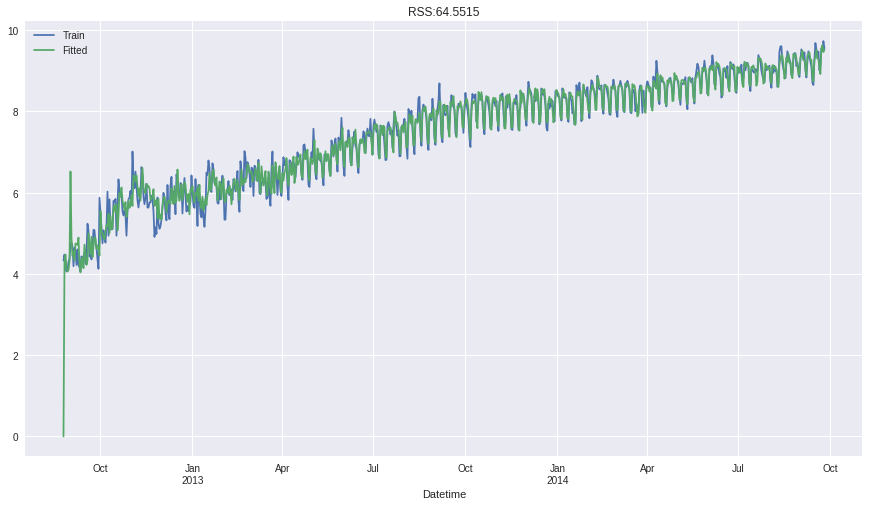

In [41]:

model2 = sm.tsa.statespace.SARIMAX(trainDay.log, order=(6, 1, 6), seasonal_order=(0,1,1,7), enforce_invertibility=False)
result2 = model2.fit()
trainDay.log.plot(label='Train')
result2.fittedvalues.plot(label='Fitted')
plt.legend(loc='best')
plt.title('RSS:{:.4f}'.format(np.sum((result2.fittedvalues - trainDay.log)**2)))
result2.summary()

### Split into train and validation

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Count   No. Observations:                  670
Model:             SARIMAX(6, 1, 6)x(0, 1, 1, 7)   Log Likelihood                  -7.693
Date:                           Sat, 12 May 2018   AIC                             43.387
Time:                                   08:12:21   BIC                            106.489
Sample:                               08-25-2012   HQIC                            67.828
                                    - 06-25-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0131      0.164     -0.080      0.936      -0.335       0.309
ar.L2         -0.0659      0.174     -0.379      0.704      -0.406       0.274
ar.L3         -0.0157      0.151     -0.104      0.917      -0.311       0.279
ar.L4         -0.0016      0.150     -0.011      0.991      -0.296       0.293
ar.L5         -0.5400      0.107     -5.033      0.000      -0.750      -0.330
ar.L6          0.3815      0.061      6.242      0.000       0.262       0.501
ma.L1         -0.4520      0.161     -2.807      0.005      -0.768      -0.136
ma.L2         -0.2374      0.147     -1.610      0.107      -0.526       0.052
ma.L3         -0.0752      0.177     -0.424      0.672      -0.423       0.273
ma.L4          0.0116      0.167      0.070      0.944      -0.315       0.339
ma.L5          0.5100      0.127      4.032      0.000       0.262       0.758
ma.L6         -0.5883      0.124     -4.733      0.000      -0.832      -0.345
ma.S.L7       -0.8817      0.024    -36.140      0.000      -0.930      -0.834
sigma2         0.0597      0.002     27.500      0.000       0.055       0.064
===================================================================================
Ljung-Box (Q):                       31.97   Jarque-Bera (JB):               513.88
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

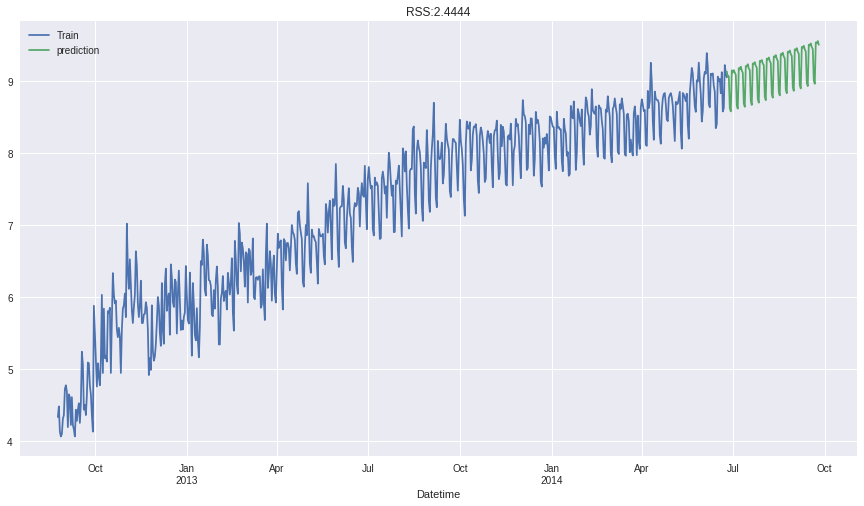

In [42]:
trainseasonal = trainDay.log.loc['2012-08-25':'2014-06-25']
trainseasonalValid = trainDay.log.loc['2014-06-25':'2014-09-25']

model3 = sm.tsa.statespace.SARIMAX(trainseasonal, order=(6, 1, 6), seasonal_order=(0,1,1,7), enforce_invertibility=False)
result3 = model3.fit()
trainseasonal.plot(label='Train')
predict3 = result3.predict(start='2014-06-25', end='2014-09-25')
predict3.plot(label='prediction')
plt.legend(loc='best')
plt.title('RSS:{:.4f}'.format(np.sum((predict3 - trainseasonalValid)**2)))
result3.summary()


### Forecast.

In [0]:
predictOut = result2.predict(start='2014-09-25', end='2015-04-26')[1:].to_frame(name='logCount')

In [0]:
predictOut['DCount'] = np.exp(predictOut.logCount)

In [46]:
predictOut['year'] = predictOut.index.year
predictOut['month'] = predictOut.index.month
predictOut['day'] = predictOut.index.day

predictOut.head()

,logCount,DCount,year,month,day
2014-09-26,9.459976,12835.574007,2014,9,26
2014-09-27,9.062525,8625.905691,2014,9,27
2014-09-28,9.042258,8452.841383,2014,9,28
2014-09-29,9.522700,13666.459761,2014,9,29
2014-09-30,9.605192,14841.640509,2014,9,30


In [118]:
merge = test.merge(predictOut, on=['year', 'month', 'day'], how='left', copy=True)
merge.head()

                                   
                                   

,ID,year,month,day,day_of_week,hour,logCount,DCount
0,18288,2014,9,26,4,0,9.459976,12835.574007
1,18289,2014,9,26,4,1,9.459976,12835.574007
2,18290,2014,9,26,4,2,9.459976,12835.574007
3,18291,2014,9,26,4,3,9.459976,12835.574007
4,18292,2014,9,26,4,4,9.459976,12835.574007


In [127]:
temp = train.groupby('hour')['Count'].sum() / train.Count.sum()
merge['ratio'] = merge.hour.map(temp)
merge['Count'] = merge.DCount * merge.ratio
merge.head()


,ID,year,month,day,day_of_week,hour,logCount,DCount,ratio,Count
0,18288,2014,9,26,4,0,9.459976,12835.574007,0.044287,568.443776
1,18289,2014,9,26,4,1,9.459976,12835.574007,0.035343,453.647873
2,18290,2014,9,26,4,2,9.459976,12835.574007,0.029911,383.925827
3,18291,2014,9,26,4,3,9.459976,12835.574007,0.024714,317.224195
4,18292,2014,9,26,4,4,9.459976,12835.574007,0.020802,267.008564


In [0]:
submission_TS_AV_Practice = merge[['ID', 'Count']]
submission_TS_AV_Practice.to_csv('submission_TS_AV_Practice.csv')

In [129]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'submission_TS_AV_Practice.csv'})
uploaded.SetContentFile('submission_TS_AV_Practice.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1zdB3hlpt_HdYiYz6teI65HyE71iFmVTC


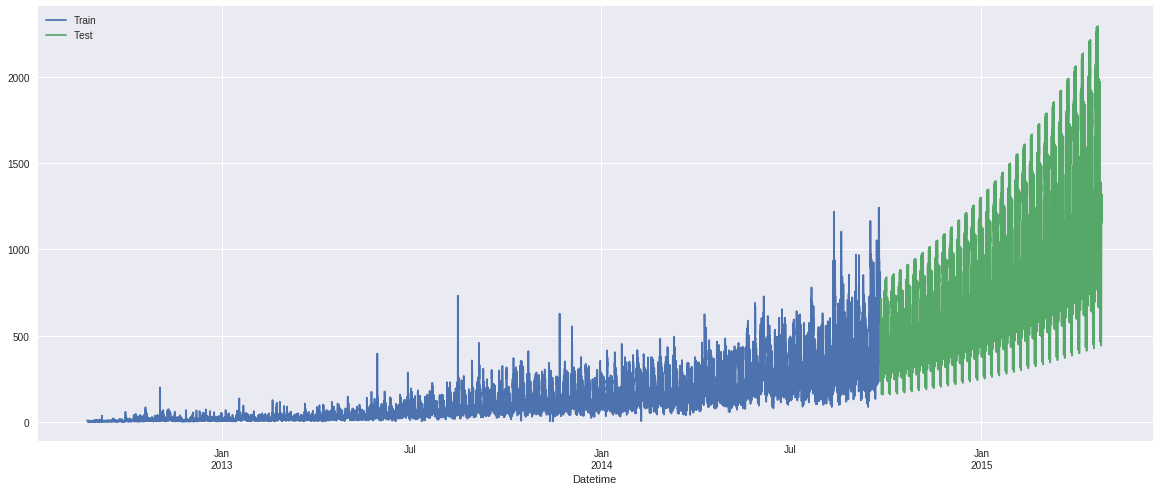

In [149]:
plt.figure(figsize=(20,8))
train.Count.plot(label='Train')
pd.Series(data=merge.Count.values, index = test.index).plot(label='Test')
plt.legend(loc='best')
plt.show()
